In [26]:
%matplotlib inline

In [2]:
import pickle as pkl
import os
from graph_tool.draw import sfdp_layout
from matplotlib import pyplot as plt

from helpers import makedir_if_not_there
from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos, query_plot_setting, visualize, default_plot_setting

In [3]:
graph_name = 'lattice-100'
g = load_graph_by_name(graph_name, suffix='_weighted_0.5')

load graph from data/lattice-100/graph_weighted_0.5.gt


In [4]:
if graph_name == 'lattice-100':
    pos = lattice_node_pos(g, shape=(10, 10))
else:
    pos = sfdp_layout(g)

In [5]:
round_id = 11
cascade_size = 0.25
obs_fraction = 0.25
cascade_model = 'si'
sampling_method = 'simulation'

In [6]:
n_queries_to_show = 30

In [7]:
data_id = '{graph_name}-m{cascade_model}-s{cascade_size}-o{obs_fraction}-omuniform'.format(
    graph_name=graph_name,
    cascade_model=cascade_model,
    cascade_size=cascade_size,
    obs_fraction=obs_fraction
)

In [8]:
query_methods = ['random', 'pagerank', 'entropy', 'cond-entropy']
(obs, c) = pkl.load(
    open('cascade-weighted/{data_id}/{round_id}.pkl'.format(
        data_id=data_id, 
        round_id=round_id),
         'rb'))

queries_by_method = {}
for query_method in query_methods:
    queries_by_method[query_method] = pkl.load(
        open('outputs/queries-weighted/{data_id}/{sampling_method}/{query_method}/{round_id}.pkl'.format(
            data_id=data_id,
            sampling_method=sampling_method,
            query_method=query_method,
            round_id=round_id),
             'rb'))[0]
n_queries = len(queries_by_method['random'])    


saving to figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11/cascade.pdf


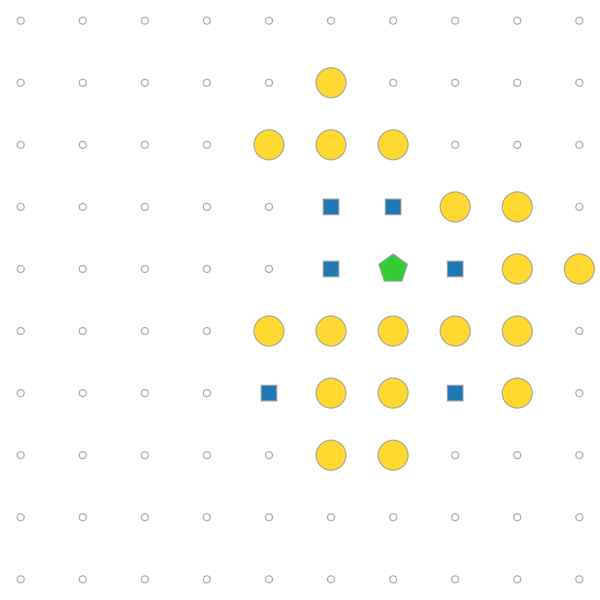

In [9]:
fig_dir = os.path.join(
    'figs/query-process-illustration',
    data_id, str(round_id)
)
makedir_if_not_there(fig_dir)

setting = default_plot_setting(g, c, obs, size_multiplier=1.5)
visualize(g, pos, **setting, output=os.path.join(fig_dir, 'cascade.pdf'))

pagerank
saving to figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11/pagerank.pdf


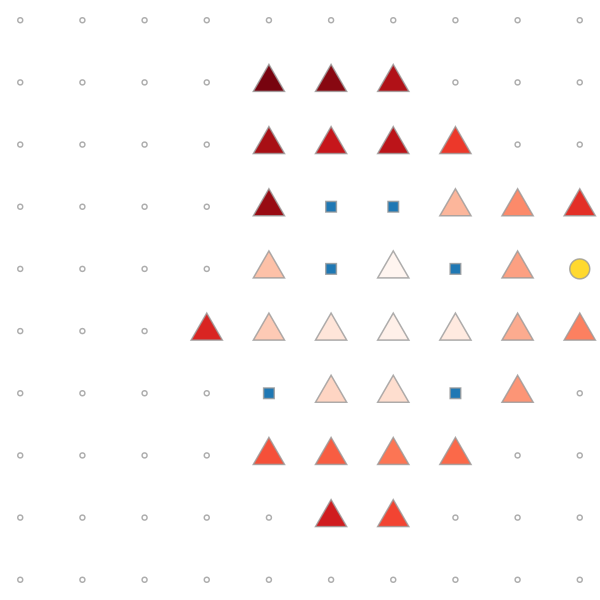

entropy
saving to figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11/entropy.pdf


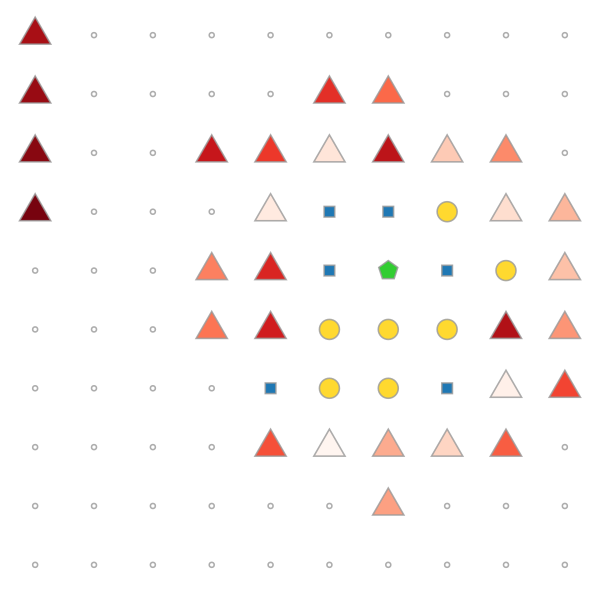

cond-entropy
saving to figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11/cond-entropy.pdf


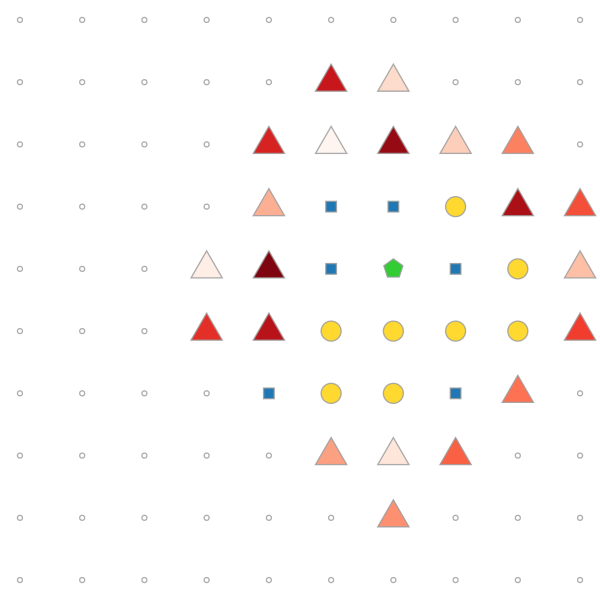

random
saving to figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11/random.pdf


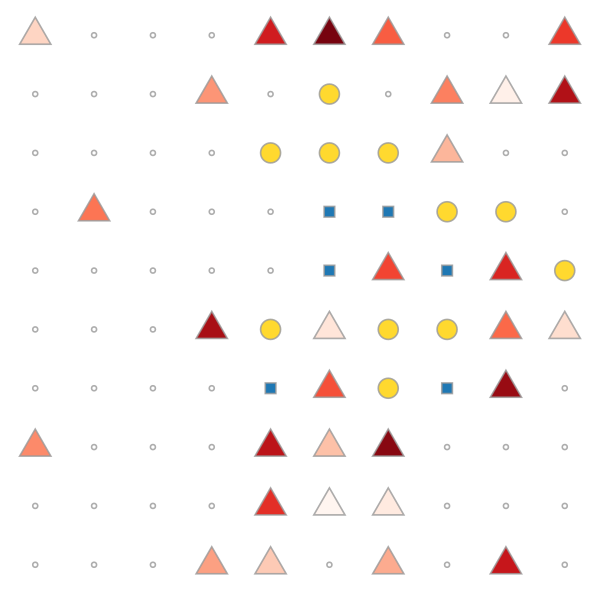

In [10]:
plt.switch_backend('cairo')

# for cls, params, name in stategies:
for name in queries_by_method:
    print(name)
    queries = queries_by_method[name][:n_queries_to_show]

    setting = query_plot_setting(
        g, c, obs, queries,
        node_size=36,
        indicator_type='color'
    )
    visualize(
        g,
        pos,
        **setting,
        output=os.path.join(fig_dir, '{}.pdf'.format(name)))

In [11]:
query_methods

['random', 'pagerank', 'entropy', 'cond-entropy']

cascade size 25
random
random 30 7
[ 0  5 10 15 20 25] [0.9015788915626364, 0.8584994993921724, 0.8817150294256249, 0.8802928841991342, 0.8418912436769579, 0.8309230917530512]
pagerank
pagerank 30 7
[ 0  5 10 15 20 25] [0.8671950298761895, 0.7084471084471085, 0.7359924026590694, 0.5537878787878788, 0.7380952380952381, 0.7]
entropy
entropy 30 7
[ 0  5 10 15 20 25] [0.8552609708737159, 0.9197107642759816, 0.941025641025641, 0.9637820512820513, 0.9924242424242424, 1.0]
cond-entropy
cond-entropy 21 6
[ 0  5 10 15 20] [0.8789170717729624, 0.9371305012389571, 0.9445681511470985, 0.9885883347421809, 1.0]
figs/query-process-illustration/lattice-100-msi-s0.25-o0.25-omuniform/11


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


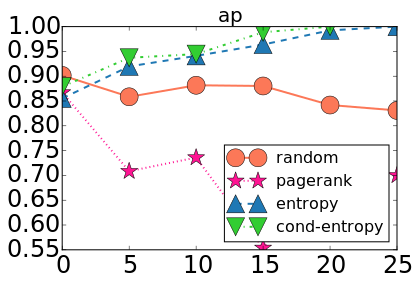

In [77]:
import numpy as np
from helpers import (
    infected_nodes, cascade_source
)
from viz_helpers import set_cycler
from eval_helpers import get_scores_by_queries

eval_method = 'ap'
every = 5

plt.style.use('paper')

query_dir = 'outputs/queries-weighted/{}/{}/'.format(data_id, sampling_method)
probas_dir = 'outputs/inf-probas-weighted/{}/{}/'.format(data_id, sampling_method)

def load_qs_and_probas(query_method):    
    print(query_method)
    query_file_path = os.path.join(query_dir, query_method, '{}.pkl'.format(round_id))
    proba_file_path = os.path.join(probas_dir, query_method, '{}.pkl'.format(round_id))

    # print('loading queries from {}'.format(query_file_path))
    # print('loading probas from {}'.format(proba_file_path))    
    
    qs, _ = pkl.load(open(query_file_path, 'rb'))
    probas = pkl.load(open(proba_file_path, 'rb'))
    qs = qs[:n_queries_to_show]
    n_probas_to_show = int(n_queries_to_show / every)
    probas = probas[:n_probas_to_show+1]
    return qs, probas

# load stuff
inf_nodes = infected_nodes(c)
source = cascade_source(c)
print('cascade size', len(infected_nodes(c)))

# plot the score

fig, ax = plt.subplots(1, 1)
set_cycler(ax)

for query_method in query_methods:
    qs, probas = load_qs_and_probas(query_method)
    print(query_method, len(qs), len(probas))    

    scores = get_scores_by_queries(
        qs, probas, c, obs, eval_method=eval_method,
        every=every,
        eval_with_mask=True,
    )

    x = np.arange(0, len(scores)) * every
    print(x, scores)
    ax.plot(x, scores)
ax.legend(query_methods, loc='best', fontsize=16)
ax.set_title(eval_method)

print(fig_dir)
fig.savefig('{}/{}_score.pdf'.format(fig_dir, eval_method))
fig.show()

random
pagerank
entropy
cond-entropy


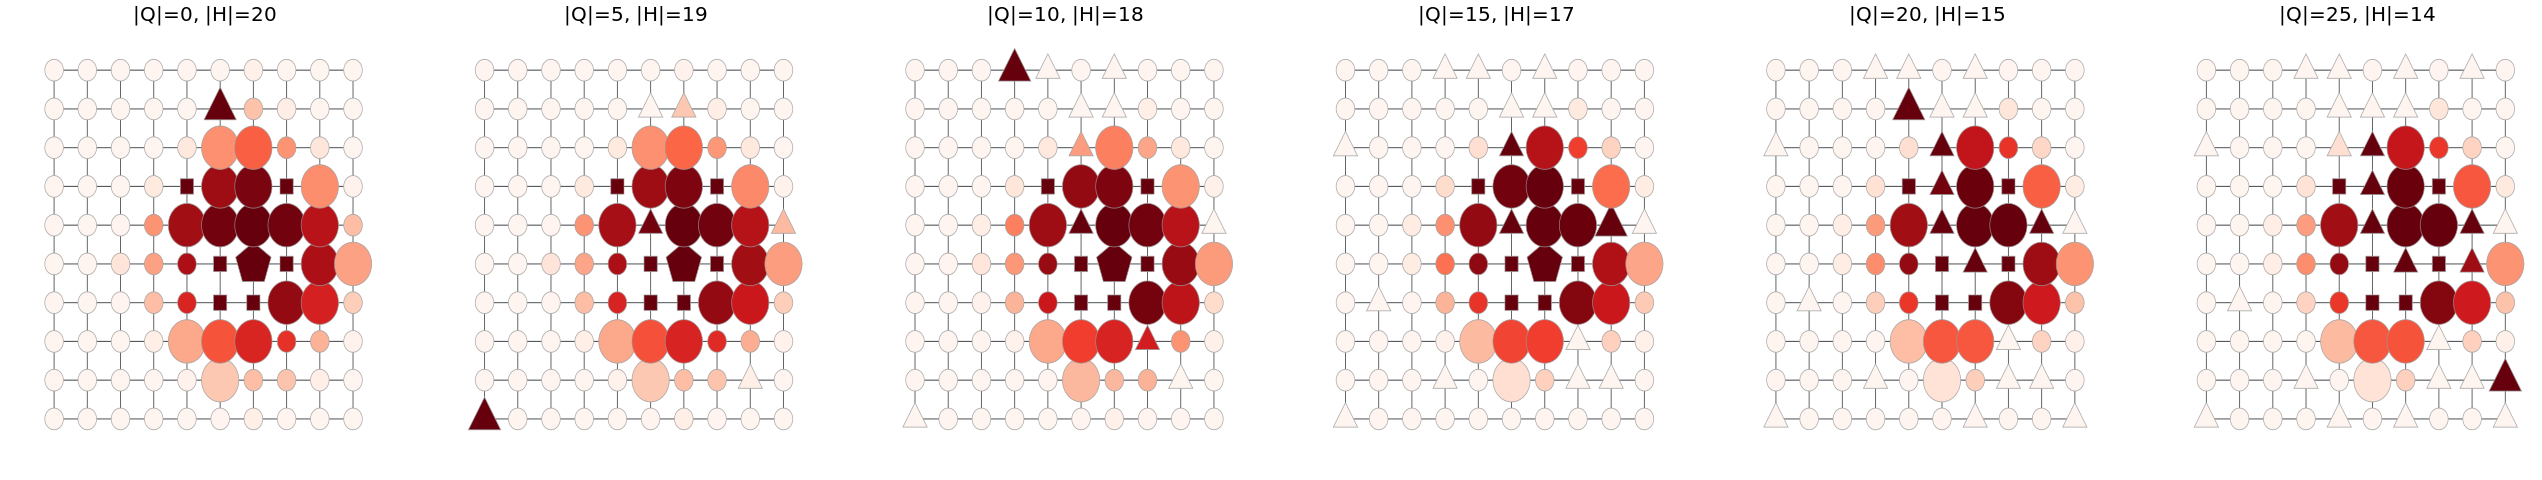

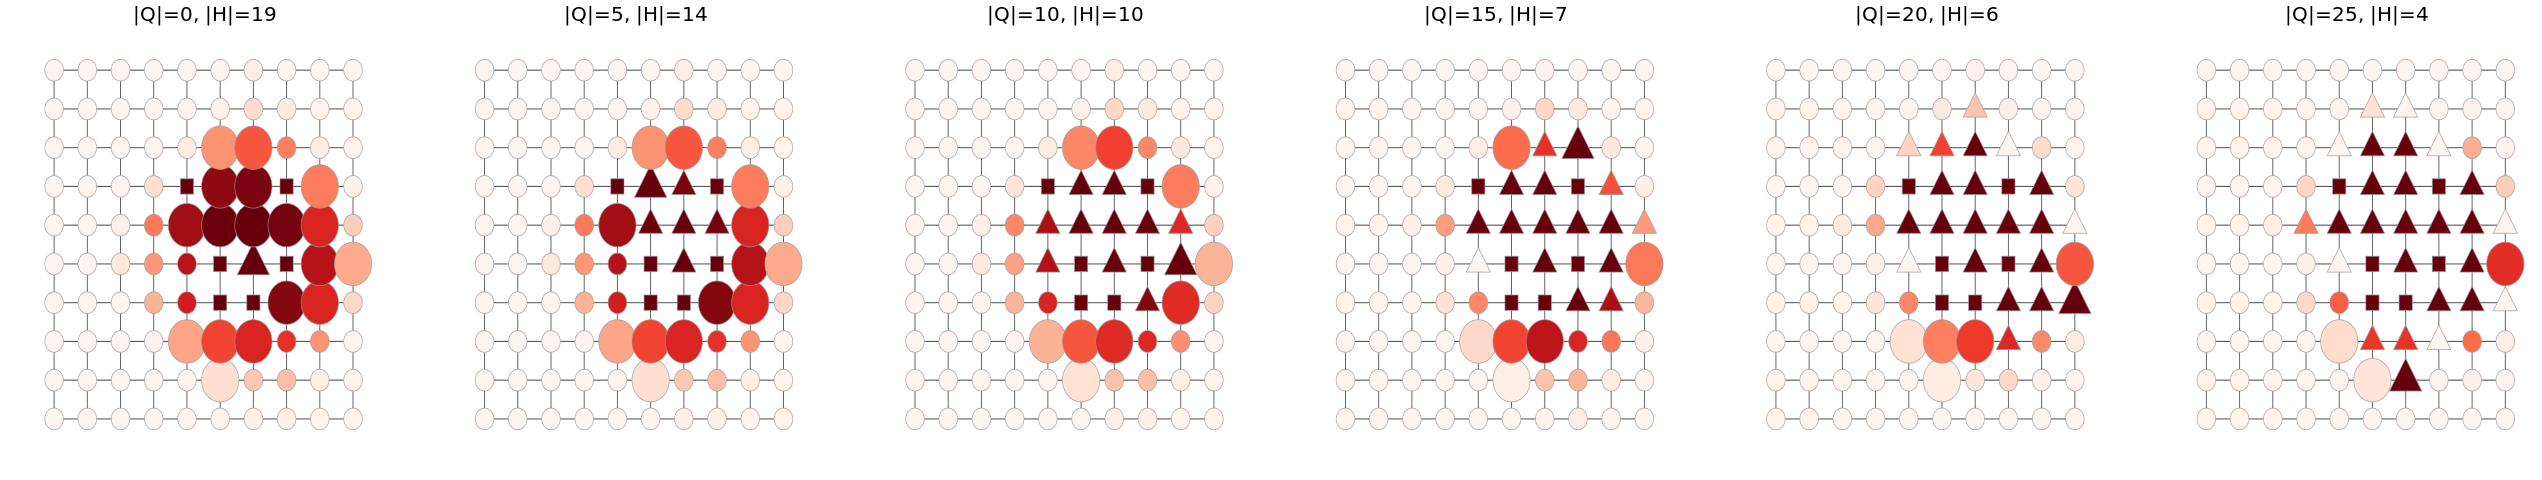

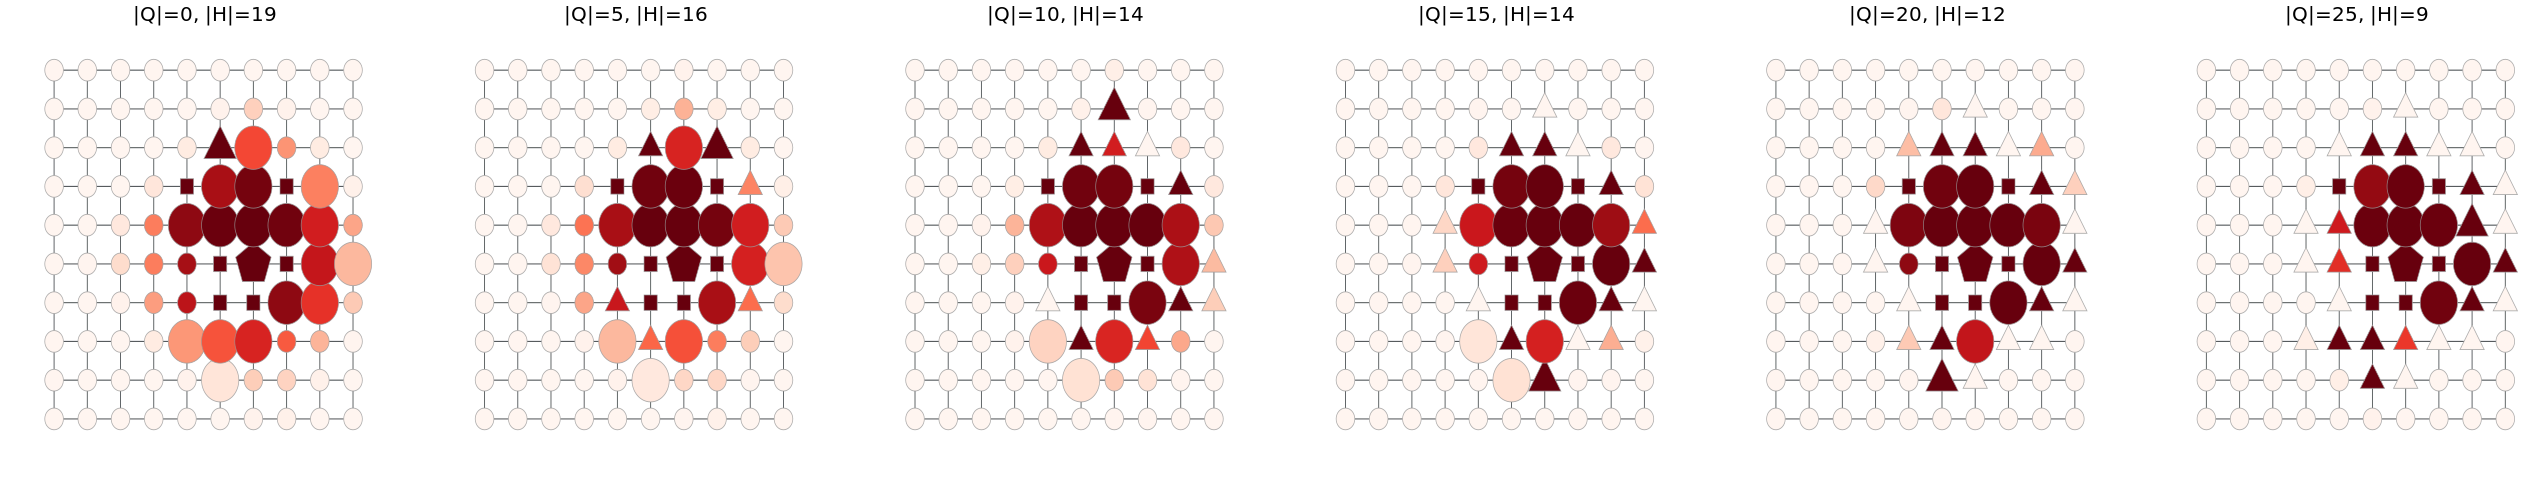

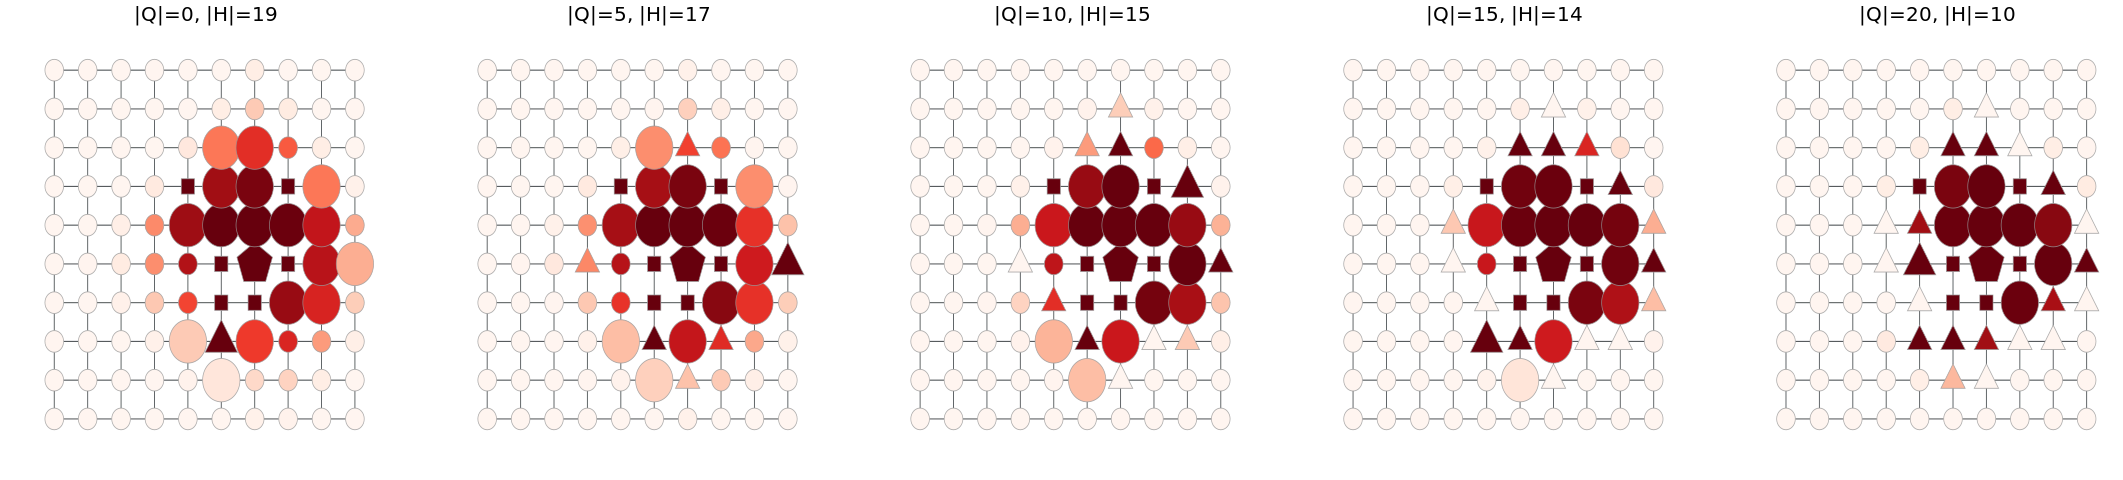

In [74]:
from viz_helpers import QueryProcessIllustrator
plt.switch_backend('cairo')

for query_method in query_methods:
    illus = QueryProcessIllustrator(
        g, obs, c, pos
    )
    qs, probas = load_qs_and_probas(query_method)
    n_col = len(probas) - 1
    size = 7.5
    fig, axes = plt.subplots(1, n_col, figsize=(n_col * size, size))
    # fig.patch.set_visible(False)
    for ax in axes:
        ax.axis('off')
    for i, q in enumerate(qs):
        illus.add_query(q)
        if i % every == 0:
            proba_index = int(i / every)
            ax = axes[proba_index]
            illus.plot_snapshot(q, probas[proba_index], ax=ax)
            title = "|Q|={n_queries}, |H|={n_hidden_infs}".format(
                n_queries=i, 
                n_hidden_infs=len(illus.hidden_inf)+1
            )
            ax.set_title(title)
    fig.savefig('{}/{}_query_process.pdf'.format(fig_dir, query_method))
